<a href="https://colab.research.google.com/github/yoav-amar/unsupervised_learning_project/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade numpy
!pip install --upgrade gensim
!pip install --upgrade nltk
!pip install --upgrade pandas
!pip install --upgrade kagglehub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 80.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━

# Importing the DB

In [ ]:
import kagglehub
from pathlib import Path
import pandas as pd

In [ ]:
CSV_NAME = "athlete_events.csv"

In [ ]:
import shutil

# Download latest version
path = kagglehub.dataset_download("heesoo37/120-years-of-olympic-history-athletes-and-results", path=CSV_NAME, force_download=True)

print("Path to dataset files:", path)
real_path = Path(path)

#real_path.rename(f"./{CSV_NAME}")
shutil.copy(path, f"./{CSV_NAME}")
print(real_path)

Path to dataset files: /kaggle/input/120-years-of-olympic-history-athletes-and-results/athlete_events.csv
/kaggle/input/120-years-of-olympic-history-athletes-and-results/athlete_events.csv


# Utils

In [ ]:
def calculate_bmi(weight: float, height: float):
    """
    Calculate BMI given weight (kg) and height (cm).

    Args:
    weight (float): Weight in kilograms
    height (float): Height in cm

    Returns:
    float: BMI value
    """
    if height <= 0 or weight <= 0:
        raise ValueError("values should be positive")

    bmi = weight / ((height / 100) ** 2)
    return round(bmi, 2)

In [ ]:
def gender_to_number(gender: str) -> int:
    if gender == "M":
        return 0
    if gender == "F":
        return 1
    raise ValueError(f"unknown gender: {gender}")

In [ ]:
def season_to_number(season: str) -> int:
    if season == "Summer":
        return 0
    if season == "Winter":
        return 1
    raise ValueError(f"unknown season: {season}")

In [ ]:
def long_event_to_short(gender: bool, sport: str, event: str) -> str:
    if not event.startswith(sport):
        raise ValueError("unknown event")
    event = event.removeprefix(sport)
    event = event.lstrip()
    string_gender = "Women's" if gender else "Men's"
    if not event.startswith(string_gender):
        if not event.startswith("Mixed"):
            raise ValueError(f"unknown event gender: {event}, {sport}")
        else:
            return event.lstrip()

    event = event.removeprefix(string_gender)
    return event.lstrip()

In [ ]:
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)  # Remove special characters
    tokens = word_tokenize(text)  # Tokenize
    return [word for word in tokens if word in model]  # Keep only words in Word2Vec model

def get_word2vec(tokens, model):
    vectors = [model[word] for word in tokens if word in model]  # Getting rid of words which are not in model
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)  # Average or return zero vector

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
CITIES_CSV = "worldcities.csv"

# Download latest version of cities DB
path = kagglehub.dataset_download("juanmah/world-cities", path=CITIES_CSV, force_download=True)

print("Path to dataset files:", path)
real_path = Path(path)

real_path.rename(f"./{CITIES_CSV}")
print(real_path)
cities = pd.read_csv(CITIES_CSV)

cities = cities[['city', 'lat', 'lng']]
cities = cities.drop_duplicates(subset='city', keep='first')

def get_coordinates(df):
  return df.merge(cities, left_on="City", right_on="city", how="left")

100%|██████████| 1.67M/1.67M [00:00<00:00, 102MB/s]

Extracting zip of worldcities.csv...
Path to dataset files: /root/.cache/kagglehub/datasets/juanmah/world-cities/versions/6/worldcities.csv
/root/.cache/kagglehub/datasets/juanmah/world-cities/versions/6/worldcities.csv


## Example Usage - Calculating BMI

In [ ]:
weight = 70  # kg
height = 175  # cm
bmi = calculate_bmi(weight, height)
print(f"BMI: {bmi}")

BMI: 22.86


# Modifying DB

In [ ]:
import pandas as pd
import numpy as np
import gensim.downloader as api

In [ ]:
original_df = pd.read_csv(CSV_NAME)
df = original_df.copy()

In [ ]:
# Remove columns without information
df.drop(columns=["NOC"], inplace=True)
df.drop(columns=["Games"], inplace=True)
df.drop(columns=["Medal"], inplace=True)
df.drop(columns=["Name"], inplace=True)

In [ ]:
# create bmi
df["BMI"] = df.apply(lambda row: calculate_bmi(row["Weight"], row["Height"]), axis=1)

In [ ]:
# remove rows with empty height and empty wight
df = df[~np.isnan(df["Height"])]
df = df[~np.isnan(df["Weight"])]

In [ ]:
# improve columns
df["Sex"] = df["Sex"].apply(gender_to_number)
df["Event"] = df.apply(lambda row: long_event_to_short(row["Sex"], row["Sport"], row["Event"]), axis=1)
df["Season"] = df["Season"].apply(season_to_number)

In [ ]:
df

,ID,Sex,Age,Height,Weight,Team,Year,Season,City,Sport,Event,BMI
0,1,0,24.0,180.0,80.0,China,1992,0,Barcelona,Basketball,Basketball,24.69
1,2,0,23.0,170.0,60.0,China,2012,0,London,Judo,Extra-Lightweight,20.76
4,5,1,21.0,185.0,82.0,Netherlands,1988,1,Calgary,Speed Skating,500 metres,23.96
5,5,1,21.0,185.0,82.0,Netherlands,1988,1,Calgary,Speed Skating,"1,000 metres",23.96
6,5,1,25.0,185.0,82.0,Netherlands,1992,1,Albertville,Speed Skating,500 metres,23.96
...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,0,29.0,179.0,89.0,Poland-1,1976,1,Innsbruck,Luge,Mixed (Men)'s Doubles,27.78
271112,135570,0,27.0,176.0,59.0,Poland,2014,1,Sochi,Ski Jumping,"Large Hill, Individual",19.05
271113,135570,0,27.0,176.0,59.0,Poland,2014,1,Sochi,Ski Jumping,"Large Hill, Team",19.05
271114,135571,0,30.0,185.0,96.0,Poland,1998,1,Nagano,Bobsleigh,Four,28.05


For the sports and the events we use a pre-trained word2vec model on Google News, found here:
[GoogleNews-DB](https://github.com/mmihaltz/word2vec-GoogleNews-vectors)

In [ ]:
model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


### Example

In [ ]:
model.most_similar("king")

[('kings', 0.7138045430183411),
 ('queen', 0.6510956883430481),
 ('monarch', 0.6413194537162781),
 ('crown_prince', 0.6204220056533813),
 ('prince', 0.6159993410110474),
 ('sultan', 0.5864824056625366),
 ('ruler', 0.5797567367553711),
 ('princes', 0.5646552443504333),
 ('Prince_Paras', 0.5432944297790527),
 ('throne', 0.5422105193138123)]

## Computing Word2Vec over Sport and Event

In [ ]:
df['Sport Tokens'] = df['Sport'].apply(preprocess_text)
df['Sport'] = df['Sport Tokens'].apply(lambda tokens: get_word2vec(tokens, model))

df['Event Tokens'] = df['Event'].apply(preprocess_text)
df['Event'] = df['Event Tokens'].apply(lambda tokens: get_word2vec(tokens, model))

In [ ]:
df.drop(columns=df.filter(regex='Tokens').columns, inplace=True)

In [ ]:
df

,ID,Sex,Age,Height,Weight,Team,Year,Season,City,Sport,Event,BMI
0,1,0,24.0,180.0,80.0,China,1992,0,Barcelona,"[-0.008544922, 0.084472656, 0.21289062, 0.1137...","[-0.008544922, 0.084472656, 0.21289062, 0.1137...",24.69
1,2,0,23.0,170.0,60.0,China,2012,0,London,"[-0.29882812, 0.002029419, 0.47460938, -0.0341...","[-0.0068359375, 0.036376953, -0.06689453, 0.02...",20.76
4,5,1,21.0,185.0,82.0,Netherlands,1988,1,Calgary,"[-0.043945312, 0.18334961, 0.26464844, 0.04931...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",23.96
5,5,1,21.0,185.0,82.0,Netherlands,1988,1,Calgary,"[-0.043945312, 0.18334961, 0.26464844, 0.04931...","[0.05078125, -0.09326172, 0.064941406, 0.11425...",23.96
6,5,1,25.0,185.0,82.0,Netherlands,1992,1,Albertville,"[-0.043945312, 0.18334961, 0.26464844, 0.04931...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",23.96
...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,0,29.0,179.0,89.0,Poland-1,1976,1,Innsbruck,"[-0.42382812, -0.25390625, 0.46679688, 0.19921...","[-0.18315125, 0.061462402, -0.036315918, 0.058...",27.78
271112,135570,0,27.0,176.0,59.0,Poland,2014,1,Sochi,"[0.0041503906, -0.06738281, 0.050048828, -0.04...","[0.08138021, 0.10432943, -0.031117758, 0.17399...",19.05
271113,135570,0,27.0,176.0,59.0,Poland,2014,1,Sochi,"[0.0041503906, -0.06738281, 0.050048828, -0.04...","[-0.038085938, 0.14038086, 0.005533854, 0.0719...",19.05
271114,135571,0,30.0,185.0,96.0,Poland,1998,1,Nagano,"[-0.453125, -0.24902344, 0.11767578, 0.0220947...","[0.0859375, -0.072753906, 0.016723633, 0.08544...",28.05


## City - Replacing with Coordinates

In [ ]:
df = get_coordinates(df)
df

,ID,Sex,Age,Height,Weight,Team,Year,Season,City,Sport,Event,BMI,city,lat,lng
0,1,0,24.0,180.0,80.0,China,1992,0,Barcelona,"[-0.008544922, 0.084472656, 0.21289062, 0.1137...","[-0.008544922, 0.084472656, 0.21289062, 0.1137...",24.69,Barcelona,41.3828,2.1769
1,2,0,23.0,170.0,60.0,China,2012,0,London,"[-0.29882812, 0.002029419, 0.47460938, -0.0341...","[-0.0068359375, 0.036376953, -0.06689453, 0.02...",20.76,London,51.5072,-0.1275
2,5,1,21.0,185.0,82.0,Netherlands,1988,1,Calgary,"[-0.043945312, 0.18334961, 0.26464844, 0.04931...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",23.96,Calgary,51.0500,-114.0667
3,5,1,21.0,185.0,82.0,Netherlands,1988,1,Calgary,"[-0.043945312, 0.18334961, 0.26464844, 0.04931...","[0.05078125, -0.09326172, 0.064941406, 0.11425...",23.96,Calgary,51.0500,-114.0667
4,5,1,25.0,185.0,82.0,Netherlands,1992,1,Albertville,"[-0.043945312, 0.18334961, 0.26464844, 0.04931...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",23.96,Albertville,34.2633,-86.2108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206848,135569,0,29.0,179.0,89.0,Poland-1,1976,1,Innsbruck,"[-0.42382812, -0.25390625, 0.46679688, 0.19921...","[-0.18315125, 0.061462402, -0.036315918, 0.058...",27.78,Innsbruck,47.2683,11.3933
206849,135570,0,27.0,176.0,59.0,Poland,2014,1,Sochi,"[0.0041503906, -0.06738281, 0.050048828, -0.04...","[0.08138021, 0.10432943, -0.031117758, 0.17399...",19.05,Sochi,43.5853,39.7203
206850,135570,0,27.0,176.0,59.0,Poland,2014,1,Sochi,"[0.0041503906, -0.06738281, 0.050048828, -0.04...","[-0.038085938, 0.14038086, 0.005533854, 0.0719...",19.05,Sochi,43.5853,39.7203
206851,135571,0,30.0,185.0,96.0,Poland,1998,1,Nagano,"[-0.453125, -0.24902344, 0.11767578, 0.0220947...","[0.0859375, -0.072753906, 0.016723633, 0.08544...",28.05,Nagano,36.6486,138.1947


In [ ]:
df.drop(columns=["city", "City"], inplace=True)

In [ ]:
df

,ID,Sex,Age,Height,Weight,Team,Year,Season,Sport,Event,BMI,lat,lng
0,1,0,24.0,180.0,80.0,China,1992,0,"[-0.008544922, 0.084472656, 0.21289062, 0.1137...","[-0.008544922, 0.084472656, 0.21289062, 0.1137...",24.69,41.3828,2.1769
1,2,0,23.0,170.0,60.0,China,2012,0,"[-0.29882812, 0.002029419, 0.47460938, -0.0341...","[-0.0068359375, 0.036376953, -0.06689453, 0.02...",20.76,51.5072,-0.1275
2,5,1,21.0,185.0,82.0,Netherlands,1988,1,"[-0.043945312, 0.18334961, 0.26464844, 0.04931...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",23.96,51.0500,-114.0667
3,5,1,21.0,185.0,82.0,Netherlands,1988,1,"[-0.043945312, 0.18334961, 0.26464844, 0.04931...","[0.05078125, -0.09326172, 0.064941406, 0.11425...",23.96,51.0500,-114.0667
4,5,1,25.0,185.0,82.0,Netherlands,1992,1,"[-0.043945312, 0.18334961, 0.26464844, 0.04931...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",23.96,34.2633,-86.2108
...,...,...,...,...,...,...,...,...,...,...,...,...,...
206848,135569,0,29.0,179.0,89.0,Poland-1,1976,1,"[-0.42382812, -0.25390625, 0.46679688, 0.19921...","[-0.18315125, 0.061462402, -0.036315918, 0.058...",27.78,47.2683,11.3933
206849,135570,0,27.0,176.0,59.0,Poland,2014,1,"[0.0041503906, -0.06738281, 0.050048828, -0.04...","[0.08138021, 0.10432943, -0.031117758, 0.17399...",19.05,43.5853,39.7203
206850,135570,0,27.0,176.0,59.0,Poland,2014,1,"[0.0041503906, -0.06738281, 0.050048828, -0.04...","[-0.038085938, 0.14038086, 0.005533854, 0.0719...",19.05,43.5853,39.7203
206851,135571,0,30.0,185.0,96.0,Poland,1998,1,"[-0.453125, -0.24902344, 0.11767578, 0.0220947...","[0.0859375, -0.072753906, 0.016723633, 0.08544...",28.05,36.6486,138.1947


In [ ]:
# Couldn't find a good db for countries data including historical data so Im using word2vec for now
df['Team Tokens'] = df['Team'].apply(preprocess_text)
df['Team'] = df['Team Tokens'].apply(lambda tokens: get_word2vec(tokens, model))
df.drop(columns=["Team Tokens"], inplace=True)
df

,ID,Sex,Age,Height,Weight,Team,Year,Season,Sport,Event,BMI,lat,lng
0,1,0,24.0,180.0,80.0,"[-0.29492188, 0.084472656, 0.010314941, 0.3457...",1992,0,"[-0.008544922, 0.084472656, 0.21289062, 0.1137...","[-0.008544922, 0.084472656, 0.21289062, 0.1137...",24.69,41.3828,2.1769
1,2,0,23.0,170.0,60.0,"[-0.29492188, 0.084472656, 0.010314941, 0.3457...",2012,0,"[-0.29882812, 0.002029419, 0.47460938, -0.0341...","[-0.0068359375, 0.036376953, -0.06689453, 0.02...",20.76,51.5072,-0.1275
2,5,1,21.0,185.0,82.0,"[-0.053222656, 0.034179688, 0.14941406, 0.2246...",1988,1,"[-0.043945312, 0.18334961, 0.26464844, 0.04931...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",23.96,51.0500,-114.0667
3,5,1,21.0,185.0,82.0,"[-0.053222656, 0.034179688, 0.14941406, 0.2246...",1988,1,"[-0.043945312, 0.18334961, 0.26464844, 0.04931...","[0.05078125, -0.09326172, 0.064941406, 0.11425...",23.96,51.0500,-114.0667
4,5,1,25.0,185.0,82.0,"[-0.053222656, 0.034179688, 0.14941406, 0.2246...",1992,1,"[-0.043945312, 0.18334961, 0.26464844, 0.04931...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",23.96,34.2633,-86.2108
...,...,...,...,...,...,...,...,...,...,...,...,...,...
206848,135569,0,29.0,179.0,89.0,"[0.07055664, -0.12963867, 0.09887695, 0.111572...",1976,1,"[-0.42382812, -0.25390625, 0.46679688, 0.19921...","[-0.18315125, 0.061462402, -0.036315918, 0.058...",27.78,47.2683,11.3933
206849,135570,0,27.0,176.0,59.0,"[0.09033203, -0.16601562, 0.1328125, 0.1088867...",2014,1,"[0.0041503906, -0.06738281, 0.050048828, -0.04...","[0.08138021, 0.10432943, -0.031117758, 0.17399...",19.05,43.5853,39.7203
206850,135570,0,27.0,176.0,59.0,"[0.09033203, -0.16601562, 0.1328125, 0.1088867...",2014,1,"[0.0041503906, -0.06738281, 0.050048828, -0.04...","[-0.038085938, 0.14038086, 0.005533854, 0.0719...",19.05,43.5853,39.7203
206851,135571,0,30.0,185.0,96.0,"[0.09033203, -0.16601562, 0.1328125, 0.1088867...",1998,1,"[-0.453125, -0.24902344, 0.11767578, 0.0220947...","[0.0859375, -0.072753906, 0.016723633, 0.08544...",28.05,36.6486,138.1947


## Flattening the DB

In [ ]:
array_columns = ['Team', 'Sport', 'Event']

In [ ]:
def expand_list_columns_chunked(df, array_columns, chunk_size=10000):
    # Expands list columns in chunks to reduce RAM usage (hopefully)
    final_df = pd.DataFrame()
    for i in range(0, df.shape[0], chunk_size):
        chunk = df.iloc[i:i + chunk_size]
        expanded_chunk = pd.DataFrame(index=chunk.index)

        for col in array_columns:
            list_of_lists = chunk[col].to_list()
            num_elements = len(list_of_lists[0])
            column_names = [f'{col}_{i+1}' for i in range(num_elements)]
            col_df = pd.DataFrame(list_of_lists, index=chunk.index, columns=column_names)
            expanded_chunk = pd.concat([expanded_chunk, col_df], axis=1)

        # Concatenate expanded chunk with final DataFrame
        final_df = pd.concat([final_df, expanded_chunk], axis=0)
        del expanded_chunk

    # Concatenate expanded data with remaining data
    other_data = df.drop(columns=array_columns)
    final_df = pd.concat([other_data, final_df], axis=1)

    return final_df


final_df = expand_list_columns_chunked(df, array_columns)

In [ ]:
final_df

,ID,Sex,Age,Height,Weight,Year,Season,BMI,lat,lng,...,Event_291,Event_292,Event_293,Event_294,Event_295,Event_296,Event_297,Event_298,Event_299,Event_300
0,1,0,24.0,180.0,80.0,1992,0,24.69,41.3828,2.1769,...,-0.265625,-0.010864,0.019775,-0.349609,0.269531,0.287109,0.129883,0.221680,0.046631,0.259766
1,2,0,23.0,170.0,60.0,2012,0,20.76,51.5072,-0.1275,...,-0.065186,-0.191895,-0.125488,-0.027954,-0.170166,-0.061035,-0.007568,-0.124023,-0.204102,0.080200
2,5,1,21.0,185.0,82.0,1988,1,23.96,51.0500,-114.0667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,5,1,21.0,185.0,82.0,1988,1,23.96,51.0500,-114.0667,...,0.029419,0.017090,-0.162109,0.144531,-0.021240,0.079590,-0.212891,-0.168945,-0.041504,0.008179
4,5,1,25.0,185.0,82.0,1992,1,23.96,34.2633,-86.2108,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206848,135569,0,29.0,179.0,89.0,1976,1,27.78,47.2683,11.3933,...,0.028015,0.037598,-0.058960,0.008301,-0.059082,-0.138199,-0.064087,-0.200043,0.163147,0.174942
206849,135570,0,27.0,176.0,59.0,2014,1,19.05,43.5853,39.7203,...,0.017253,0.104398,-0.166667,-0.017985,-0.088013,0.053874,-0.033529,0.003255,0.087138,-0.037537
206850,135570,0,27.0,176.0,59.0,2014,1,19.05,43.5853,39.7203,...,-0.020589,0.115303,-0.233073,-0.037679,-0.026123,0.057129,-0.074117,-0.035156,0.051432,-0.056681
206851,135571,0,30.0,185.0,96.0,1998,1,28.05,36.6486,138.1947,...,-0.071289,0.022217,-0.151367,-0.151367,-0.088867,0.074707,-0.071777,-0.013489,-0.186523,-0.040039


In [ ]:
df = final_df.dropna()  # Remove rows with NaN values
df

,ID,Sex,Age,Height,Weight,Year,Season,BMI,lat,lng,...,Event_291,Event_292,Event_293,Event_294,Event_295,Event_296,Event_297,Event_298,Event_299,Event_300
0,1,0,24.0,180.0,80.0,1992,0,24.69,41.3828,2.1769,...,-0.265625,-0.010864,0.019775,-0.349609,0.269531,0.287109,0.129883,0.221680,0.046631,0.259766
1,2,0,23.0,170.0,60.0,2012,0,20.76,51.5072,-0.1275,...,-0.065186,-0.191895,-0.125488,-0.027954,-0.170166,-0.061035,-0.007568,-0.124023,-0.204102,0.080200
2,5,1,21.0,185.0,82.0,1988,1,23.96,51.0500,-114.0667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,5,1,21.0,185.0,82.0,1988,1,23.96,51.0500,-114.0667,...,0.029419,0.017090,-0.162109,0.144531,-0.021240,0.079590,-0.212891,-0.168945,-0.041504,0.008179
4,5,1,25.0,185.0,82.0,1992,1,23.96,34.2633,-86.2108,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206848,135569,0,29.0,179.0,89.0,1976,1,27.78,47.2683,11.3933,...,0.028015,0.037598,-0.058960,0.008301,-0.059082,-0.138199,-0.064087,-0.200043,0.163147,0.174942
206849,135570,0,27.0,176.0,59.0,2014,1,19.05,43.5853,39.7203,...,0.017253,0.104398,-0.166667,-0.017985,-0.088013,0.053874,-0.033529,0.003255,0.087138,-0.037537
206850,135570,0,27.0,176.0,59.0,2014,1,19.05,43.5853,39.7203,...,-0.020589,0.115303,-0.233073,-0.037679,-0.026123,0.057129,-0.074117,-0.035156,0.051432,-0.056681
206851,135571,0,30.0,185.0,96.0,1998,1,28.05,36.6486,138.1947,...,-0.071289,0.022217,-0.151367,-0.151367,-0.088867,0.074707,-0.071777,-0.013489,-0.186523,-0.040039


In [ ]:
df.to_csv("bla.csv", index=False)

# TSNE

In [ ]:
!pip install --upgrade --force-reinstall threadpoolctl
!pip install --upgrade numpy scipy joblib
!pip install --upgrade --force-reinstall sklearn
!pip install --upgrade --force-reinstall matplotlib

DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/MulticoreTSNE-0.1-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.6.0
    Uninstalling threadpoolctl-3.6.0:
      Successfully uninstalled threadpoolctl-3.6.0
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/MulticoreTSNE-0.1-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/MulticoreTSNE-0.1-py3.1

In [ ]:
!git clone https://github.com/DmitryUlyanov/Multicore-TSNE.git
%cd Multicore-TSNE
!python setup.py build
!python setup.py install
%cd ..

fatal: destination path 'Multicore-TSNE' already exists and is not an empty directory.
/content/Multicore-TSNE
/usr/local/lib/python3.11/dist-packages/setuptools/__init__.py:94: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/dist.py:261: UserWarning: Unknown distribution option: 'test_suite'
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/dist.py:261: UserWarning: Unknown distribution option: 'tests_require'
  warnings.warn(msg)
running build
running build_py
copying MulticoreTSNE/__init__.py -> bui

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from MulticoreTSNE import MulticoreTSNE as TSNE

In [ ]:
import pandas as pd
df = pd.read_csv("bla.csv")
X = df.values  # Features
X_scaled = StandardScaler().fit_transform(X)

## Checking TSNE over Some Samples

In [ ]:
df_sample = df.sample(n=5000, random_state=42)  # Select 5000 random samples
X_sample = df_sample.values
X_sample_scaled = StandardScaler().fit_transform(X_sample)

In [ ]:
df_sample

,ID,Sex,Age,Height,Weight,Year,Season,BMI,lat,lng,...,Event_291,Event_292,Event_293,Event_294,Event_295,Event_296,Event_297,Event_298,Event_299,Event_300
33986,27270,0,25.0,165.0,55.0,1956,0,20.20,-37.8142,144.9631,...,-0.110352,-0.336914,-0.201172,-0.188965,-0.109863,-0.261230,0.032715,0.098389,0.146484,0.129395
93412,72202,0,24.0,187.0,86.0,1972,0,24.59,48.1375,11.5750,...,0.138672,0.026489,0.165039,-0.225586,0.421875,-0.125977,0.246094,-0.009705,-0.056152,0.265625
29816,23828,0,27.0,173.0,65.0,1976,1,21.72,47.2683,11.3933,...,0.133057,-0.259277,-0.265137,0.012695,0.047424,0.044922,0.050781,0.016479,-0.072693,-0.194336
172327,132403,1,15.0,160.0,54.0,2008,0,21.09,39.9067,116.3975,...,-0.075684,-0.084961,-0.129883,-0.045654,0.039307,-0.160156,0.136719,0.255859,0.593750,0.032715
102778,79470,0,32.0,167.0,74.0,2016,0,26.53,-22.9111,-43.2056,...,-0.119141,-0.381836,-0.216309,0.005615,-0.028320,-0.271484,0.042969,0.012207,0.190430,-0.142578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54546,43045,0,24.0,177.0,65.0,1988,0,20.75,37.5600,126.9900,...,-0.019653,-0.080040,-0.123901,0.032715,-0.020996,-0.018433,0.132080,0.095337,-0.115845,-0.118286
117692,90916,0,24.0,184.0,83.0,1968,0,24.52,19.4333,-99.1333,...,0.132385,-0.088501,-0.070251,-0.189941,0.051758,-0.117432,0.045898,0.112427,0.158691,0.042236
22186,17746,0,26.0,183.0,82.0,1972,0,24.49,48.1375,11.5750,...,0.120768,-0.121094,-0.291667,-0.074504,0.050578,0.001953,0.013835,-0.044189,0.136108,0.046305
78520,61393,0,31.0,173.0,69.0,1936,0,23.05,52.5200,13.4050,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
pca = PCA(n_components=50)

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, n_jobs=-1, random_state=42)

In [ ]:
X_pca1 = pca.fit_transform(X_sample_scaled)

In [ ]:
X_tsne1 = tsne.fit_transform(X_pca1)

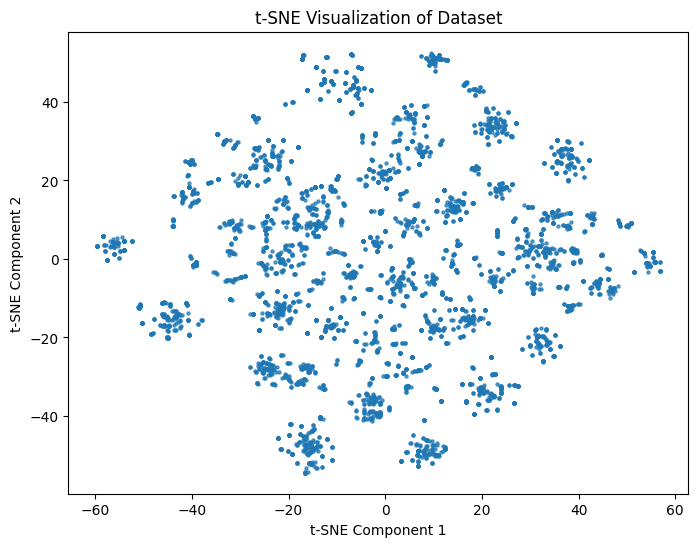

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne1[:, 0], X_tsne1[:, 1], alpha=0.7, s=5)
plt.title('t-SNE Visualization of Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [ ]:
df_sample2 = df.sample(n=5000, random_state=11)
X_sample2 = df_sample.values
X_sample_scaled2 = StandardScaler().fit_transform(X_sample2)

In [ ]:
df_sample2

,ID,Sex,Age,Height,Weight,Year,Season,BMI,lat,lng,...,Event_291,Event_292,Event_293,Event_294,Event_295,Event_296,Event_297,Event_298,Event_299,Event_300
93928,72604,0,26.0,167.0,64.0,1980,0,22.95,37.6567,69.6292,...,-0.201172,-0.291901,-0.235657,0.030762,-0.125977,-0.143799,-0.157227,0.038696,0.147461,-0.093018
119280,92154,1,26.0,170.0,65.0,2002,1,22.49,40.7776,-111.9311,...,0.165039,0.182617,-0.283203,-0.298828,0.050049,0.065430,-0.152344,-0.156250,0.281250,0.247070
135277,104321,0,24.0,180.0,103.0,1988,0,31.79,37.5600,126.9900,...,0.036102,-0.016113,-0.209839,-0.186035,0.004395,-0.227051,-0.062462,0.062073,0.000305,-0.076782
119138,92034,0,26.0,178.0,78.0,1968,1,24.62,45.1715,5.7224,...,-0.071289,0.022217,-0.151367,-0.151367,-0.088867,0.074707,-0.071777,-0.013489,-0.186523,-0.040039
138526,106815,0,31.0,180.0,70.0,2010,1,21.60,49.2500,-123.1000,...,0.250000,-0.279297,-0.308594,-0.171875,-0.259766,-0.109375,0.249023,0.128906,0.190430,-0.051758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134439,103702,0,26.0,185.0,84.0,1988,0,24.54,37.5600,126.9900,...,-0.102051,-0.263672,0.185547,-0.177734,0.050537,0.267578,0.410156,0.141602,-0.376953,-0.134766
136695,105395,0,19.0,183.0,76.0,1972,0,22.69,48.1375,11.5750,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
150534,115993,0,32.0,184.0,83.0,1968,0,24.52,19.4333,-99.1333,...,-0.040558,-0.058655,-0.093506,-0.012230,-0.058857,-0.050781,0.073425,-0.019379,0.105225,-0.063553
135908,104828,0,30.0,176.0,73.0,1980,0,23.57,37.6567,69.6292,...,-0.013232,-0.043408,-0.066797,-0.025684,-0.096631,-0.054395,-0.029395,-0.033569,0.002380,-0.026636


In [ ]:
X_pca2 = pca.fit_transform(X_sample_scaled2)

In [ ]:
X_tsne2 = tsne.fit_transform(X_pca2)

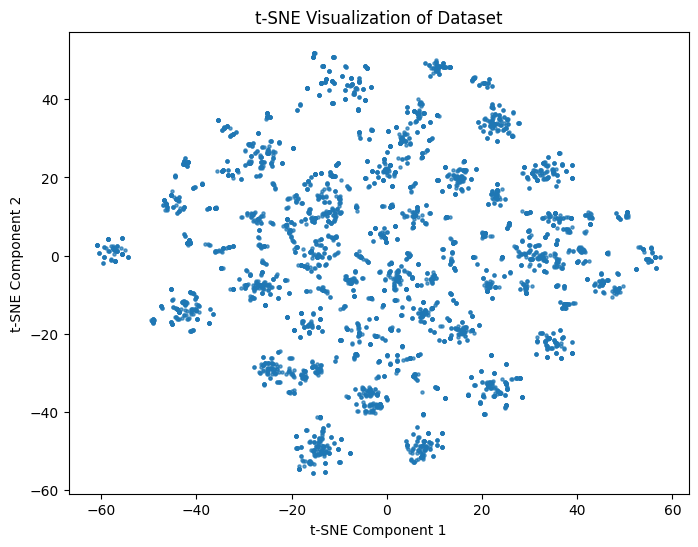

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne2[:, 0], X_tsne2[:, 1], alpha=0.7, s=5)
plt.title('t-SNE Visualization of Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

## TSNE Over 50,000 Samples

In [ ]:
df_sample = df.sample(n=50000, random_state=37)  # Select 50000 random samples
X_sample = df_sample.values
X_sample_scaled = StandardScaler().fit_transform(X_sample)

In [ ]:
df_sample

,ID,Sex,Age,Height,Weight,Year,Season,BMI,lat,lng,...,Event_291,Event_292,Event_293,Event_294,Event_295,Event_296,Event_297,Event_298,Event_299,Event_300
148705,114687,0,21.0,180.0,70.0,1972,0,21.60,48.1375,11.5750,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11660,9469,0,27.0,163.0,54.0,1984,1,20.32,43.8564,18.4131,...,0.133057,-0.259277,-0.265137,0.012695,0.047424,0.044922,0.050781,0.016479,-0.072693,-0.194336
85615,66478,1,33.0,168.0,47.0,2000,0,16.65,-33.8678,151.2100,...,-0.225586,0.310547,-0.175781,0.141602,0.072266,0.059814,-0.037354,-0.279297,-0.079590,-0.073242
89059,69117,0,22.0,202.0,88.0,2008,0,21.57,39.9067,116.3975,...,-0.000122,0.017883,-0.081543,-0.011536,0.032288,-0.038860,-0.131836,-0.037659,0.091248,-0.046936
168238,129405,1,18.0,146.0,51.0,1964,0,23.93,35.6897,139.6922,...,-0.012268,-0.023438,-0.042480,-0.150391,0.074219,-0.143555,0.232422,0.175781,0.628906,-0.081543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81482,63485,0,29.0,181.0,88.0,1984,1,26.86,43.8564,18.4131,...,-0.079712,-0.196777,0.092784,-0.115723,0.060913,0.124329,0.303711,0.167480,-0.264648,-0.307617
62847,49545,0,31.0,174.0,70.0,1960,0,23.12,26.4166,-99.0061,...,0.006226,0.024251,-0.160970,0.027059,-0.007894,-0.034342,-0.083984,-0.151286,0.124186,0.059774
24092,19253,0,22.0,178.0,60.0,1994,1,18.94,61.1167,10.4667,...,0.017253,0.104398,-0.166667,-0.017985,-0.088013,0.053874,-0.033529,0.003255,0.087138,-0.037537
69501,54559,0,23.0,160.0,55.0,1996,0,21.48,33.7628,-84.4220,...,-0.075928,0.090658,-0.091960,-0.072347,-0.101034,0.078613,0.059021,0.018392,-0.084310,-0.023275


### With PCA

In [ ]:
pca = PCA(n_components=50)

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, n_jobs=-1, random_state=42)

In [ ]:
X_pca1 = pca.fit_transform(X_sample_scaled)

In [ ]:
X_tsne1 = tsne.fit_transform(X_pca1)

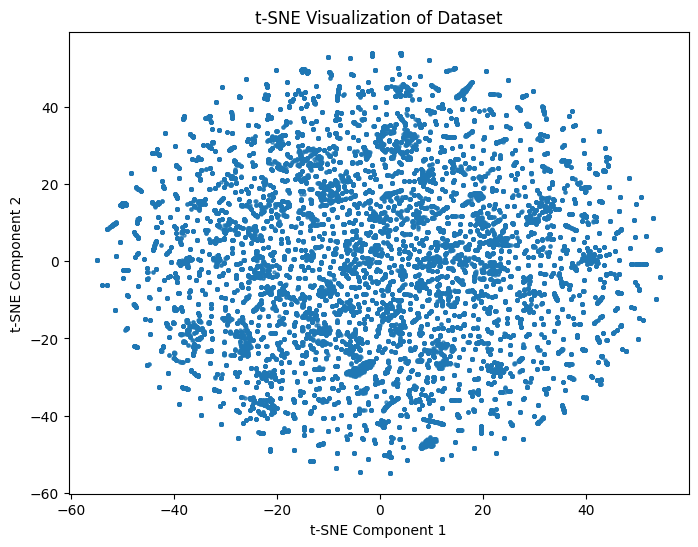

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne1[:, 0], X_tsne1[:, 1], alpha=0.7, s=5)
plt.title('t-SNE Visualization of Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

### With MCA

In [ ]:
!pip install prince

DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/MulticoreTSNE-0.1-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [ ]:
import prince

mca = prince.MCA(n_components=2, random_state=24)
#mca_result = mca.fit(df_sample).transform(df_sample) # Notebook Crashes


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import TruncatedSVD

encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_encoded = encoder.fit_transform(df_sample)

svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(X_encoded)

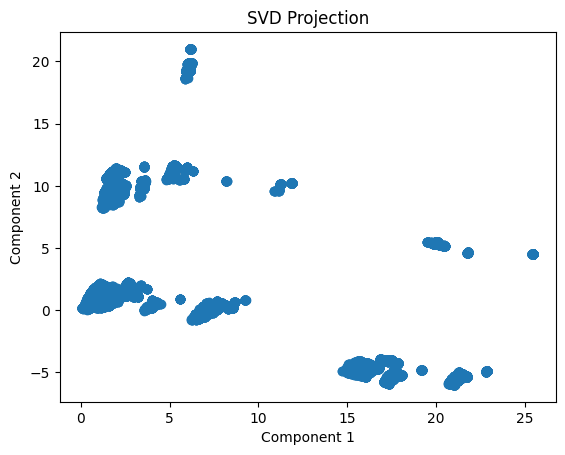

In [ ]:
# Visualize
import matplotlib.pyplot as plt

plt.scatter(X_svd[:, 0], X_svd[:, 1])
plt.title("SVD Projection")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


In [ ]:
# TSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=10, random_state=42)
tsne_result = tsne.fit_transform(X_svd)


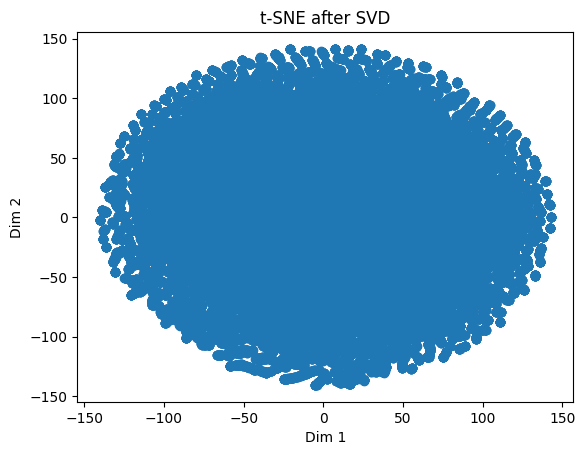

In [ ]:
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.title("t-SNE after SVD")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()

## Running Algorithms

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


range_k = range(2, 20)
silhouette_scores = []
all_labels = []

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_svd)
    score = silhouette_score(tsne_result, labels)
    silhouette_scores.append(score)
    all_labels.append(labels)
    print(f"K = {k}, Silhouette Score = {score:.3f}")


K = 2, Silhouette Score = 0.245
K = 3, Silhouette Score = 0.270
K = 4, Silhouette Score = 0.196
K = 5, Silhouette Score = 0.114
K = 6, Silhouette Score = 0.090
K = 7, Silhouette Score = 0.076
K = 8, Silhouette Score = 0.110
K = 9, Silhouette Score = 0.131
K = 10, Silhouette Score = 0.110
K = 11, Silhouette Score = 0.101
K = 12, Silhouette Score = 0.095
K = 13, Silhouette Score = 0.090
K = 14, Silhouette Score = 0.119
K = 15, Silhouette Score = 0.092
K = 16, Silhouette Score = 0.097
K = 17, Silhouette Score = 0.073
K = 18, Silhouette Score = 0.087
K = 19, Silhouette Score = 0.089


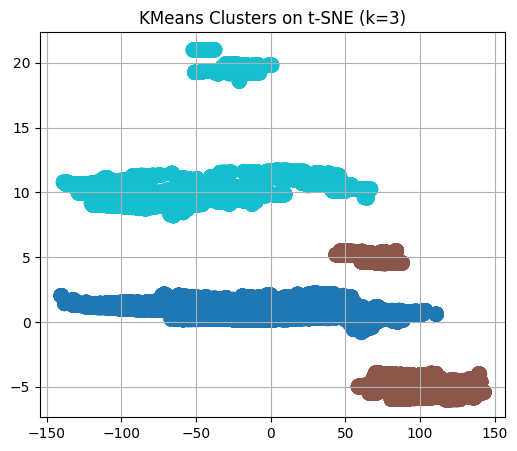

In [ ]:
best_k_index = silhouette_scores.index(max(silhouette_scores))
best_k = range_k[best_k_index]
best_labels = all_labels[best_k_index]

plt.figure(figsize=(6, 5))
plt.scatter(tsne_result[:, 0], X_svd[:, 1], c=best_labels, cmap='tab10', s=100)
plt.title(f"KMeans Clusters on SVD (k={best_k})")
plt.grid(True)
plt.show()

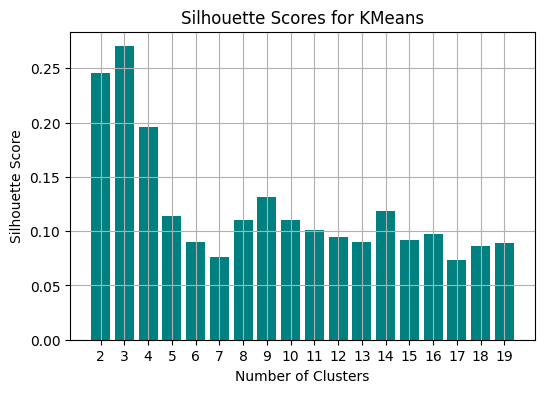

In [ ]:
plt.figure(figsize=(6, 4))
plt.bar([str(k) for k in range_k], silhouette_scores, color='teal')
plt.title("Silhouette Scores for KMeans")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=5, min_samples=2)
labels = dbscan.fit_predict(X_svd)
score = silhouette_score(X_svd, labels)


plt.figure(figsize=(6, 5))
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=labels, cmap='tab10')
plt.title(f"HDBSCAN")
plt.grid(True)
plt.show()

## TSNE Overall

In [ ]:
X_pca = pca.fit_transform(X_scaled)

In [ ]:
X_tsne = tsne.fit_transform(X_pca)

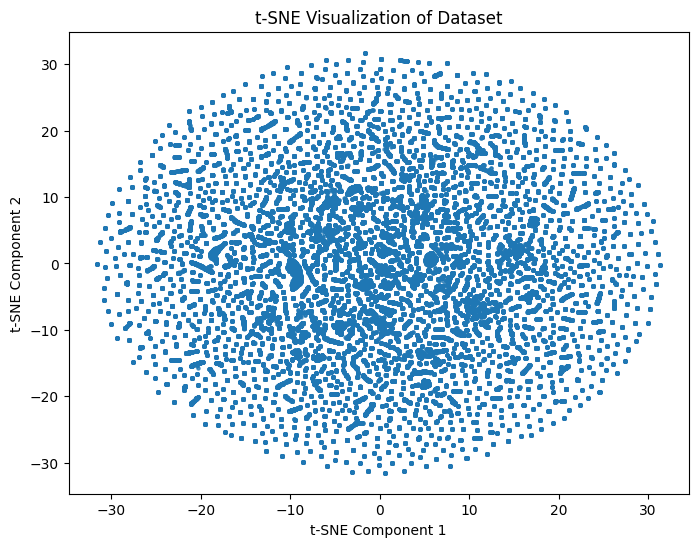

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7, s=5)
plt.title('t-SNE Visualization of Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [ ]:
import numpy as np
np.savetxt("tsne_results.csv", X_tsne, delimiter=",")
np.savetxt("pca_results.csv", X_pca, delimiter=",")

# Checking if Data is Clustered

In [ ]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


In [ ]:
import numpy as np
X_tsne = np.loadtxt("tsne_results.csv", delimiter=",")

## DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
X_tsne_scaled = X_tsne #StandardScaler().fit_transform(X_tsne)
dbscan = DBSCAN(eps=0.6, min_samples=3, n_jobs=-1).fit(X_tsne_scaled)
labels = dbscan.fit_predict(X_tsne_scaled)

if len(set(labels)) > 1:
    score = silhouette_score(X_tsne_scaled, labels)
    print("Silhouette Score:", score)
    print(f"number of labels: {len(labels)}")
else:
    print("DBSCAN found no clusters")

NameError: name 'X_tsne' is not defined

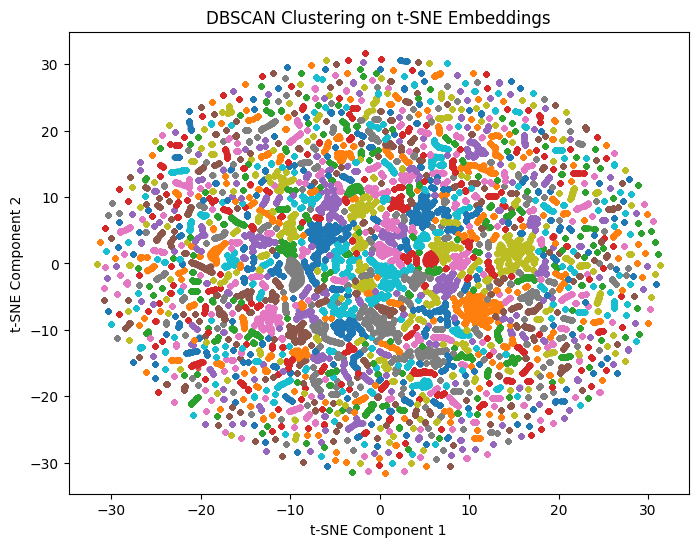

In [ ]:
plt.figure(figsize=(8, 6))
unique_labels = np.unique(labels)

for label in unique_labels:
    cluster_points = X_tsne[labels == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], alpha=0.7, s=10)

plt.title("DBSCAN Clustering on t-SNE Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [ ]:
len(labels)

176950

## KMEANS

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_tsne)

sil_score_kmeans = silhouette_score(X_tsne, kmeans_labels)
print(f"Silhouette Score (K-Means): {sil_score_kmeans}")


Silhouette Score (K-Means): 0.3338638451804621


### Kmeans with different clusters

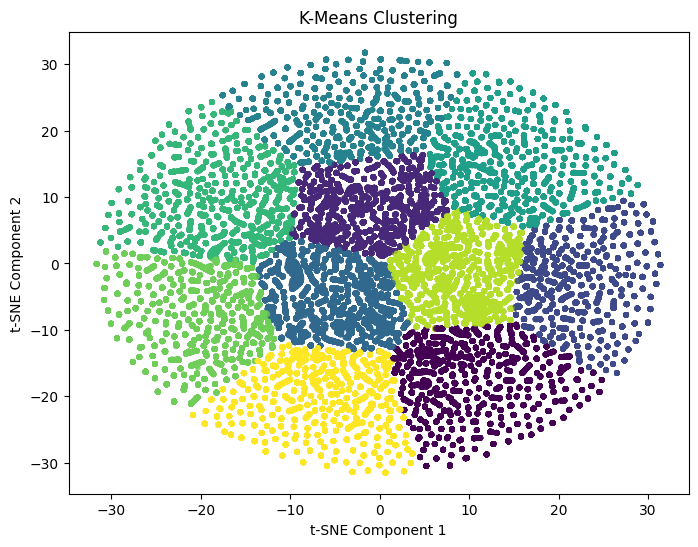

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7, s=10)
plt.title('K-Means Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

## Agglomerative Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering

agg_clustering = AgglomerativeClustering(n_clusters=5)
agg_labels = agg_clustering.fit_predict(X_tsne)

sil_score_agg = silhouette_score(X_tsne, agg_labels)
print(f"Silhouette Score (Agglomerative): {sil_score_agg}")


In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=agg_labels, cmap='viridis', alpha=0.7, s=10)
plt.title('Agglomerative Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

## GMM

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=50, random_state=42)
gmm_labels = gmm.fit_predict(X_tsne)

sil_score_gmm = silhouette_score(X_tsne, gmm_labels)
print(f"Silhouette Score (GMM): {sil_score_gmm}")

Silhouette Score (GMM): 0.3138068162905272


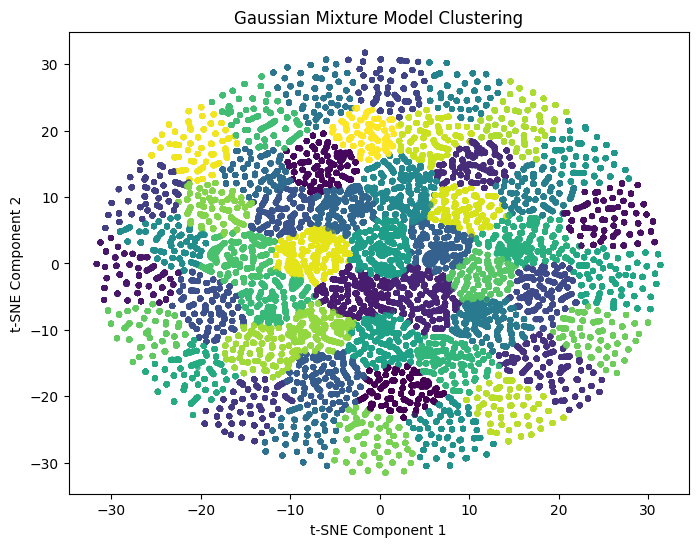

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=gmm_labels, cmap='viridis', alpha=0.7, s=10)
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

## HDBSCAN

In [ ]:
import hdbscan

hdb = hdbscan.HDBSCAN(min_cluster_size=10)
hdb_labels = hdb.fit_predict(X_tsne)

# HDBSCAN returns -1 for noise points, so we exclude them for silhouette scoring
valid_labels_hdb = hdb_labels[hdb_labels != -1]
valid_points_hdb = X_tsne[hdb_labels != -1]

if len(valid_labels_hdb) > 1:
    sil_score_hdb = silhouette_score(valid_points_hdb, valid_labels_hdb)
    print(f"Silhouette Score (HDBSCAN): {sil_score_hdb}")
else:
    print("HDBSCAN: Not enough clusters for silhouette score.")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Silhouette Score (HDBSCAN): 0.8639352464262303


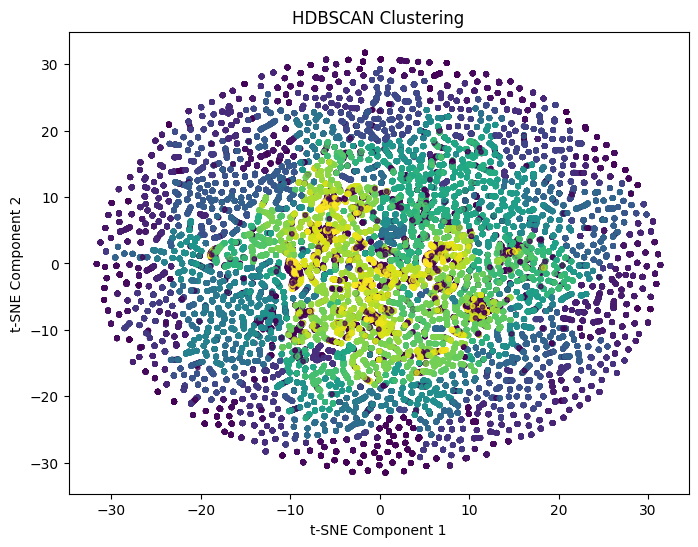

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=hdb_labels, cmap='viridis', alpha=0.7, s=10)
plt.title('HDBSCAN Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [ ]:
import collections

cluster_counts = collections.Counter(hdb_labels)
print("Cluster Sizes:", cluster_counts)

Cluster Sizes: Counter({np.int64(-1): 11993, np.int64(3297): 220, np.int64(1869): 207, np.int64(5005): 205, np.int64(4001): 191, np.int64(1550): 191, np.int64(2492): 187, np.int64(3952): 187, np.int64(285): 184, np.int64(1817): 180, np.int64(590): 178, np.int64(1420): 175, np.int64(5090): 166, np.int64(4384): 164, np.int64(2186): 160, np.int64(383): 154, np.int64(1824): 152, np.int64(2720): 147, np.int64(2301): 144, np.int64(773): 144, np.int64(2962): 139, np.int64(561): 139, np.int64(1269): 135, np.int64(5094): 132, np.int64(4236): 125, np.int64(5395): 125, np.int64(1549): 125, np.int64(3349): 124, np.int64(1575): 124, np.int64(5072): 124, np.int64(2359): 124, np.int64(3563): 124, np.int64(1591): 124, np.int64(1476): 123, np.int64(1292): 123, np.int64(2089): 123, np.int64(2618): 123, np.int64(299): 122, np.int64(3031): 122, np.int64(5111): 122, np.int64(2697): 121, np.int64(930): 121, np.int64(4626): 121, np.int64(5393): 119, np.int64(1650): 118, np.int64(3904): 117, np.int64(1401): 1

In [ ]:
min_size = 200
large_clusters = [cluster for cluster, count in cluster_counts.items()
    if cluster !=-1 and count >= min_size]
print(large_clusters)
print(f"There are {len(large_clusters)} clusters with at least {min_size} points.")
for cluster_id in np.unique(large_clusters):
     print(f"\nCluster {cluster_id}:")
     indices = df.index[hdb_labels == cluster_id]
     print(original_df.loc[indices].head())


[np.int64(3297), np.int64(5005), np.int64(1869)]
There are 3 clusters with at least 200 points.

Cluster 1869:


NameError: name 'original_df' is not defined

## Fuzzy C-Means

In [ ]:
!pip install fuzzy-c-means

DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/MulticoreTSNE-0.1-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: typer
    Found existing installation: typer 0.15.2
    Uninstalling typer-0.15.2:
      Successfully uninstalled typer-0.15.2
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      

In [ ]:
from fcmeans import FCM

fcm = FCM(n_clusters=50)
fcm.fit(X_tsne)

fcm_labels = fcm.predict(X_tsne)

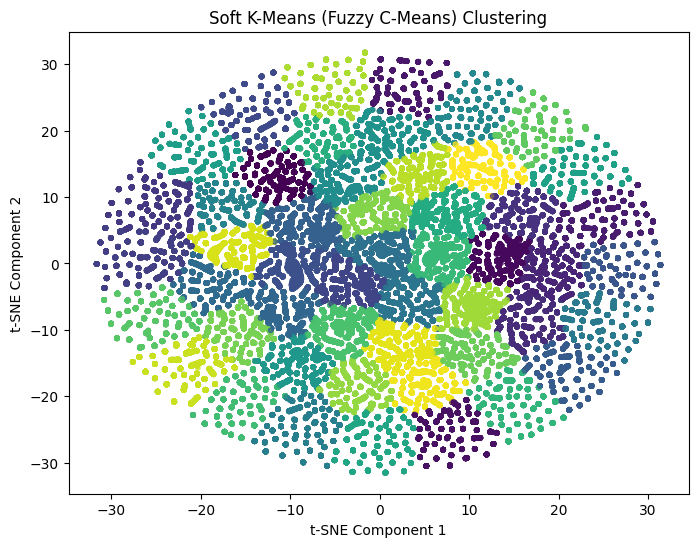

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=fcm_labels, cmap='viridis', alpha=0.7, s=10)
plt.title('Soft K-Means (Fuzzy C-Means) Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

## Spectral Clustering

In [ ]:
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=50, affinity='nearest_neighbors', random_state=42)
spectral_labels = spectral.fit_predict(X_tsne)

sil_score_spectral = silhouette_score(X_tsne, spectral_labels)
print(f"Silhouette Score (Spectral Clustering): {sil_score_spectral}")

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Silhouette Score (Spectral Clustering): -0.7285585573879565


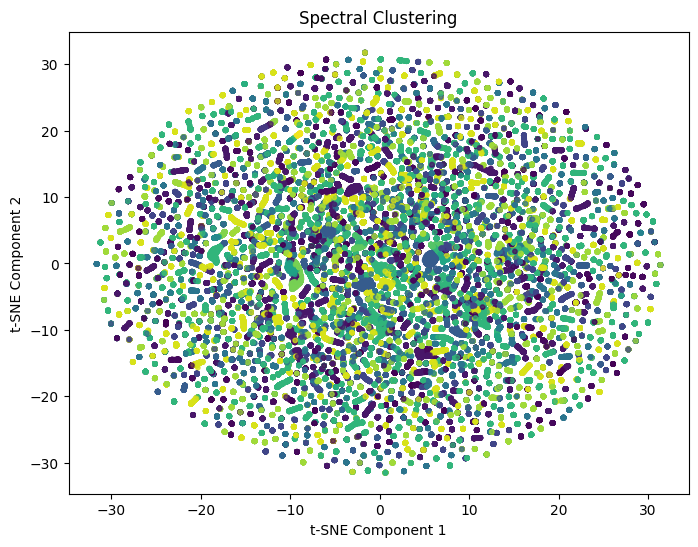

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=spectral_labels, cmap='viridis', alpha=0.7, s=10)
plt.title('Spectral Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# PCA

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
pca_to_plot = PCA(n_components=2)
X_pca = np.loadtxt("pca_results.csv", delimiter=",")
X_pca_scaled = StandardScaler().fit_transform(X_pca)
X_pca_to_plot = pca_to_plot.fit_transform(X_pca_scaled)

## DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
dbscan = DBSCAN(eps=0.6, min_samples=3, n_jobs=-1).fit(X_pca)
labels = dbscan.fit_predict(X_pca)

if len(set(labels)) > 1:
    score = silhouette_score(X_pca, labels)
    print("Silhouette Score:", score)
else:
    print("DBSCAN found no clusters")

Silhouette Score: 0.7852263848650419


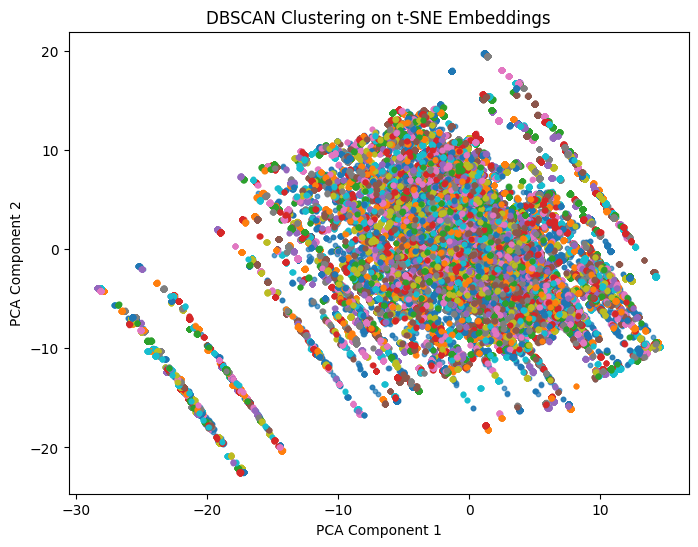

In [ ]:
from sklearn.decomposition import PCA

pca_to_plot = PCA(n_components=2)

plt.figure(figsize=(8, 6))
unique_labels = np.unique(labels)

for label in unique_labels:
    cluster_points = X_pca_scaled[labels == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], alpha=0.7, s=10)

plt.title("DBSCAN Clustering on t-SNE Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

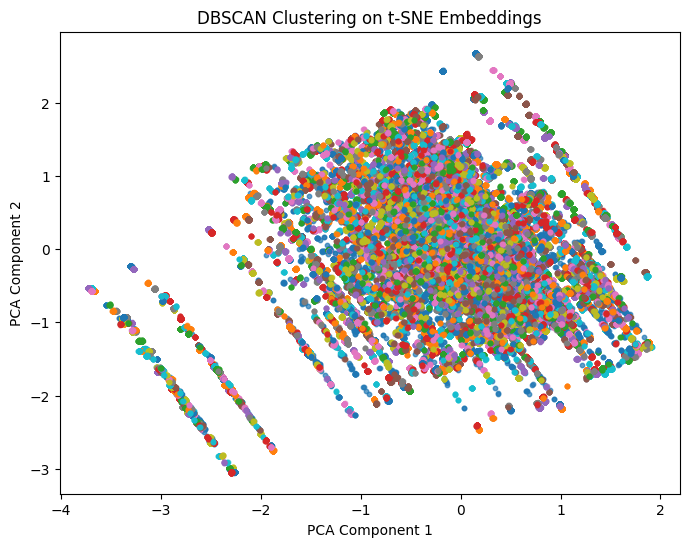

In [ ]:
from sklearn.decomposition import PCA

pca_to_plot = PCA(n_components=2)

plt.figure(figsize=(8, 6))
unique_labels = np.unique(labels)

for label in unique_labels:
    cluster_points = X_pca_scaled[labels == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], alpha=0.7, s=10)

plt.title("DBSCAN Clustering on t-SNE Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [ ]:
len(labels)

176950

## KMEANS

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca_scaled)

sil_score_kmeans = silhouette_score(X_pca_scaled, kmeans_labels)
print(f"Silhouette Score (K-Means): {sil_score_kmeans}")


Silhouette Score (K-Means): 0.04259796005472495


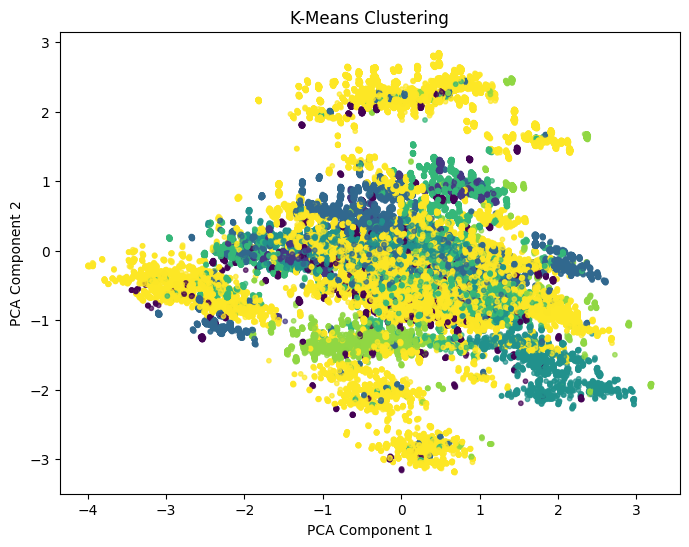

In [ ]:
kplt.figure(figsize=(8, 6))
plt.scatter(X_pca_to_plot[:, 0], X_pca_to_plot[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7, s=10)
plt.title('K-Means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()